In [2]:
import pandas as pd
import numpy as np
import re
file_name_noLable = 'tweets_remaining_09042020_16072020.csv'
file_name_withLable = 'archive_2/training.1600000.processed.noemoticon.csv'
data = pd.read_csv(file_name_noLable, sep=';').set_index('id')
labled_data = pd.read_csv(file_name_withLable,sep=',',encoding='latin-1')
labled_data.columns = ['label','id','date','query','user','text']

In [3]:
from tqdm import tqdm
import time
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
data

,created_at,full_text
id,,
1,2020-04-09 23:59:51+00:00,@KennyDegu very very little volume. With $10T ...
2,2020-04-09 23:58:55+00:00,#ES_F achieved Target 2780 closing above 50% #...
3,2020-04-09 23:58:52+00:00,RT @KimbleCharting: Silver/Gold indicator crea...
4,2020-04-09 23:58:27+00:00,@Issaquahfunds Hedged our $MSFT position into ...
5,2020-04-09 23:57:59+00:00,RT @zipillinois: 3 Surprisingly Controversial ...
...,...,...
938668,2020-07-16 00:00:25+00:00,RT @MadMraket: We tend to spend lot of time in...
938669,2020-07-16 00:00:23+00:00,You \n\n$SPX $SPY #ES_F
938670,2020-07-16 00:00:23+00:00,"$KO Coca-Cola #Options #maxpain Chart, Open In..."


In [5]:
#count sentiments in labled data
labled_data['label'].value_counts()

4    800000
0    799999
Name: label, dtype: int64

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
labled_data
pd.options.display.max_colwidth = 150

In [8]:
import collections
ticker_pattern = re.compile(r'(^\$[A-Z]+|^\$ES_F)')
ht_pattern = re.compile(r'#\w+')

ticker_dic = collections.defaultdict(int)
ht_dic = collections.defaultdict(int)
for text in data['full_text']:
    for word in text.split():
        if ticker_pattern.fullmatch(word) is not None:
            ticker_dic[word[1:]] += 1
        
        word = word.lower()
        if ht_pattern.fullmatch(word) is not None:
            ht_dic[word] += 1

In [9]:

ticker_df = pd.DataFrame.from_dict(
    ticker_dic, orient='index').rename(columns={0:'count'})\
    .sort_values('count', ascending=False).head(20)

In [10]:
ticker_dic

defaultdict(int,
            {'SPX': 131745,
             'SPY': 86173,
             'MSFT': 46676,
             'GILD': 7049,
             'MO': 783,
             'PFE': 10517,
             'JNK': 313,
             'USD': 2528,
             'AAPL': 91959,
             'UMRX': 87,
             'DECN': 424,
             'OPGN': 190,
             'CODX': 2184,
             'HTBX': 483,
             'TNXP': 451,
             'BA': 20638,
             'APRN': 678,
             'JNUG': 663,
             'PCTL': 706,
             'BIEI': 155,
             'NBY': 396,
             'UBER': 3614,
             'WTRH': 411,
             'NOVN': 713,
             'TSLA': 42441,
             'XSPA': 1719,
             'INO': 4766,
             'ASTC': 70,
             'MRNA': 5743,
             'GPMT': 64,
             'SPXS': 271,
             'QQQ': 37360,
             'NUGT': 333,
             'BURG': 39,
             'VXRT': 1386,
             'TVIX': 1612,
             'IBIO': 1777,
          

In [11]:
#first row of ticker_df
top5_tickers = ticker_df.index.values[0:7]
ticker_df.iloc[0:7]

,count
SPX,131745
AAPL,91959
SPY,86173
AMZN,81800
FB,66527
MSFT,46676
TSLA,42441


In [12]:
top7_dataframe_noLable = data[data['full_text'].str.contains('|'.join(top5_tickers))]

In [13]:
print(top7_dataframe_noLable['full_text'].head(10))

id
1                                                 @KennyDegu very very little volume. With $10T you'd think they could have $SPX  trading at 10,000 by now.
2     #ES_F achieved Target 2780 closing above 50% #Fibonacci  level, momentum still up. possible push towards 2842-2886 next week. $SPX $SPY  #tradign ...
4                                                       @Issaquahfunds Hedged our $MSFT position into close. Seemed to be getting lazy over this past week.
10                                            RT @NorthmanTrader: I repeat: The Fed is recklessly distorting everything.\n$JNK $SPX https://t.co/fDHaY5MKUW
12         S&amp;P 500 | $SPX | $SPX500 $USD\n\nlong term from 1940\n\nLong or short it with BTC on Trade8: https://t.co/Yn1Wyxwotl https://t.co/TU21nc1eA5
13           RT @TDANetwork: 📽️ #TheWatchList panel assesses the big questions $AAPL will face over the next 6 months. 🍎📱\n\n@LanceUlanoff and @mattswider…
14    $UMRX bouncing. EXTREMELY OVERSOLD #Coronavirus💸\n$DECN

In [14]:
top7_dataframe_noLable['full_text'] = top7_dataframe_noLable['full_text'].apply(lambda x: x.lower())
labled_data['text'] = labled_data['text'].apply(lambda x: x.lower())
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [15]:
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
labled_data['text'] = labled_data['text'].apply(lambda text: cleaning_stopwords(text))
top7_dataframe_noLable['full_text'] = top7_dataframe_noLable['full_text'].apply(lambda text: cleaning_stopwords(text))
top7_dataframe_noLable.tail(10)

,created_at,full_text
id,,
938652,2020-07-16 00:02:21+00:00,lows. shaping another nice sell off end year. #economy recovering fine &amp; companies adapting long term goal. $spx &amp; $ndx may overshot. mark...
938656,2020-07-16 00:01:48+00:00,@_seandavid could make good case $aapl $msft $amzn $goog $fb growth stocks value stocks large cap fund manager justify buying them.
938657,2020-07-16 00:01:25+00:00,major world indices: $spx: 3221.10 $ftse: 6299.63 $dax: 12906.19 $nikkei: 22910.48 https://t.co/jbuj8gzfwh
938658,2020-07-16 00:01:05+00:00,"via psk2329: $cmcsa comcast's nbc peacock streaming service launches today, but cnet reports roku amazon not stream $amzn $roku $amzn"
938659,2020-07-16 00:01:05+00:00,rt @tradewithdough: #india adding millions new internet users every month. next frontier big tech? $googl $fb seem thi…
938660,2020-07-16 00:01:02+00:00,#stocks near 52w low (%) $spx $spy 1. 🇺🇸 pilgrim's pride corp. $ppc: 4.4 2. 🇺🇸 molson coors beverag. $tap: 5.7 3. 🇺🇸 albertsons companies. $aci: 6...
938662,2020-07-16 00:00:57+00:00,rt @warlustrades: $spx spy #es_f #amd ⚠️ compressed volatility + tight range = big move incoming ⚠️ elliott wave 🌊 hints explosive mov…
938663,2020-07-16 00:00:55+00:00,"$cmcsa comcast's nbc peacock streaming service launches today, but cnet reports roku amazon not stream $amzn $roku"
938668,2020-07-16 00:00:25+00:00,rt @madmraket: tend spend lot time big tech names $aapl $msft $nflx $amzn good learn bio . medical devices . good bio can…


In [16]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
labled_data['text'] = labled_data['text'].apply(lambda text: cleaning_punctuations(text))
top7_dataframe_noLable['full_text'] = top7_dataframe_noLable['full_text'].apply(lambda text: cleaning_punctuations(text))
top7_dataframe_noLable.tail(10)

,created_at,full_text
id,,
938652,2020-07-16 00:02:21+00:00,lows shaping another nice sell off end year economy recovering fine amp companies adapting long term goal spx amp ndx may overshot market no mans ...
938656,2020-07-16 00:01:48+00:00,seandavid could make good case aapl msft amzn goog fb growth stocks value stocks large cap fund manager justify buying them
938657,2020-07-16 00:01:25+00:00,major world indices spx 322110 ftse 629963 dax 1290619 nikkei 2291048 httpstcojbuj8gzfwh
938658,2020-07-16 00:01:05+00:00,via psk2329 cmcsa comcasts nbc peacock streaming service launches today but cnet reports roku amazon not stream amzn roku amzn
938659,2020-07-16 00:01:05+00:00,rt tradewithdough india adding millions new internet users every month next frontier big tech googl fb seem thi…
938660,2020-07-16 00:01:02+00:00,stocks near 52w low spx spy 1 🇺🇸 pilgrims pride corp ppc 44 2 🇺🇸 molson coors beverag tap 57 3 🇺🇸 albertsons companies aci 63 4 🇺🇸 legend biotech...
938662,2020-07-16 00:00:57+00:00,rt warlustrades spx spy esf amd ⚠️ compressed volatility tight range big move incoming ⚠️ elliott wave 🌊 hints explosive mov…
938663,2020-07-16 00:00:55+00:00,cmcsa comcasts nbc peacock streaming service launches today but cnet reports roku amazon not stream amzn roku
938668,2020-07-16 00:00:25+00:00,rt madmraket tend spend lot time big tech names aapl msft nflx amzn good learn bio medical devices good bio can…


In [17]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
labled_data['text'] = labled_data['text'].apply(lambda text: cleaning_repeating_char(text))
top7_dataframe_noLable['full_text'] = top7_dataframe_noLable['full_text'].apply(lambda text: cleaning_repeating_char(text))
top7_dataframe_noLable.tail(10)

,created_at,full_text
id,,
938652,2020-07-16 00:02:21+00:00,lows shaping another nice sell off end year economy recovering fine amp companies adapting long term goal spx amp ndx may overshot market no mans ...
938656,2020-07-16 00:01:48+00:00,seandavid could make good case aapl msft amzn goog fb growth stocks value stocks large cap fund manager justify buying them
938657,2020-07-16 00:01:25+00:00,major world indices spx 3210 ftse 629963 dax129019 nikkei 221048 httpstcojbuj8gzfwh
938658,2020-07-16 00:01:05+00:00,via psk2329 cmcsa comcasts nbc peacock streaming service launches today but cnet reports roku amazon not stream amzn roku amzn
938659,2020-07-16 00:01:05+00:00,rt tradewithdough india adding millions new internet users every month next frontier big tech googl fb seem thi…
938660,2020-07-16 00:01:02+00:00,stocks near 52w low spx spy1 🇺🇸 pilgrims pride corp ppc 44 2 🇺🇸 molson coors beverag tap 57 3 🇺🇸 albertsons companies aci 63 4 🇺🇸 legend biotech ...
938662,2020-07-16 00:00:57+00:00,rt warlustrades spx spy esf amd ⚠️ compressed volatility tight range big move incoming ⚠️ elliott wave 🌊 hints explosive mov…
938663,2020-07-16 00:00:55+00:00,cmcsa comcasts nbc peacock streaming service launches today but cnet reports roku amazon not stream amzn roku
938668,2020-07-16 00:00:25+00:00,rt madmraket tend spend lot time big tech names aapl msft nflx amzn good learn bio medical devices good bio can…


In [18]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
labled_data['text'] = labled_data['text'].apply(lambda text: cleaning_URLs(text))
top7_dataframe_noLable['full_text'] = top7_dataframe_noLable['full_text'].apply(lambda text: cleaning_URLs(text))
top7_dataframe_noLable.tail(10)

,created_at,full_text
id,,
938652,2020-07-16 00:02:21+00:00,lows shaping another nice sell off end year economy recovering fine amp companies adapting long term goal spx amp ndx may overshot market no mans ...
938656,2020-07-16 00:01:48+00:00,seandavid could make good case aapl msft amzn goog fb growth stocks value stocks large cap fund manager justify buying them
938657,2020-07-16 00:01:25+00:00,major world indices spx 3210 ftse 629963 dax129019 nikkei 221048 httpstcojbuj8gzfwh
938658,2020-07-16 00:01:05+00:00,via psk2329 cmcsa comcasts nbc peacock streaming service launches today but cnet reports roku amazon not stream amzn roku amzn
938659,2020-07-16 00:01:05+00:00,rt tradewithdough india adding millions new internet users every month next frontier big tech googl fb seem thi…
938660,2020-07-16 00:01:02+00:00,stocks near 52w low spx spy1 🇺🇸 pilgrims pride corp ppc 44 2 🇺🇸 molson coors beverag tap 57 3 🇺🇸 albertsons companies aci 63 4 🇺🇸 legend biotech ...
938662,2020-07-16 00:00:57+00:00,rt warlustrades spx spy esf amd ⚠️ compressed volatility tight range big move incoming ⚠️ elliott wave 🌊 hints explosive mov…
938663,2020-07-16 00:00:55+00:00,cmcsa comcasts nbc peacock streaming service launches today but cnet reports roku amazon not stream amzn roku
938668,2020-07-16 00:00:25+00:00,rt madmraket tend spend lot time big tech names aapl msft nflx amzn good learn bio medical devices good bio can…


In [19]:
def cleaning_numbers(data):
    return re.sub(r'[\W_]+',' ',data) 
labled_data['text'] = labled_data['text'].apply(lambda text: cleaning_numbers(text))
top7_dataframe_noLable['full_text'] = top7_dataframe_noLable['full_text'].apply(lambda text: cleaning_numbers(text))
dup_labled_data = labled_data.copy()
dup_top7_noLable = top7_dataframe_noLable.copy()
top7_dataframe_noLable.tail(10)


,created_at,full_text
id,,
938652,2020-07-16 00:02:21+00:00,lows shaping another nice sell off end year economy recovering fine amp companies adapting long term goal spx amp ndx may overshot market no mans ...
938656,2020-07-16 00:01:48+00:00,seandavid could make good case aapl msft amzn goog fb growth stocks value stocks large cap fund manager justify buying them
938657,2020-07-16 00:01:25+00:00,major world indices spx 3210 ftse 629963 dax129019 nikkei 221048 httpstcojbuj8gzfwh
938658,2020-07-16 00:01:05+00:00,via psk2329 cmcsa comcasts nbc peacock streaming service launches today but cnet reports roku amazon not stream amzn roku amzn
938659,2020-07-16 00:01:05+00:00,rt tradewithdough india adding millions new internet users every month next frontier big tech googl fb seem thi
938660,2020-07-16 00:01:02+00:00,stocks near 52w low spx spy1 pilgrims pride corp ppc 44 2 molson coors beverag tap 57 3 albertsons companies aci 63 4 legend biotech corpo legn 1 ...
938662,2020-07-16 00:00:57+00:00,rt warlustrades spx spy esf amd compressed volatility tight range big move incoming elliott wave hints explosive mov
938663,2020-07-16 00:00:55+00:00,cmcsa comcasts nbc peacock streaming service launches today but cnet reports roku amazon not stream amzn roku
938668,2020-07-16 00:00:25+00:00,rt madmraket tend spend lot time big tech names aapl msft nflx amzn good learn bio medical devices good bio can


In [20]:
top5copyLable = labled_data.copy()
top5copynoLable = top7_dataframe_noLable.copy()
from nltk.tokenize import RegexpTokenizer
# tokenize words in the text
tokenizer = RegexpTokenizer(r'\w+')
labled_data['text'] = labled_data['text'].apply(lambda text: tokenizer.tokenize(text))
top7_dataframe_noLable['full_text'] = top7_dataframe_noLable['full_text'].apply(lambda text: tokenizer.tokenize(text))


In [21]:
labled_data['text']

0          [upset, cant, update, facebook, texting, it, might, cry, result, school, today, also, blah]
1                            [kenichan, dived, many, times, ball, managed, save, 50, rest, go, bounds]
2                                                              [whole, body, feels, itchy, like, fire]
3                [nationwideclass, no, its, not, behaving, all, im, mad, here, cant, see, over, there]
4                                                                         [kwesidei, not, whole, crew]
                                                      ...                                             
1599994                                                    [woke, up, no, school, best, feeling, ever]
1599995                             [thewdbcom, cool, hear, old, walt, interviews, â, httpblipfm8bmta]
1599996                                                          [ready, mojo, makeover, ask, details]
1599997                                 [happy, 38th, birthday, boo, alll

In [22]:
labled_data = labled_data.sample(n=200000,random_state=2)
import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
labled_data['text']= labled_data['text'].apply(lambda x: stemming_on_text(x))
top7_dataframe_noLable['full_text']= top7_dataframe_noLable['full_text'].apply(lambda x: stemming_on_text(x))
labled_data['text']

670081                                                                                            [lock, down, overnight]
408251     [think, times, youre, quotonquot, youre, supposed, quotoffquot, vice, versa, cuz, body, shut, today, patoowee]
1559738                                                                          [painted, blackrolling, stonesthe, best]
571248                                                                                 [maudies, one, last, lunch, girls]
524639                                                           [kid, brother, fell, off, tree, hospital, got, no, news]
                                                                ...                                                      
772541                                                                                              [last, day, vacation]
459600                                                            [confessions, follow, followers, followers, im, guilty]
381591                  

In [23]:
nltk.download('wordnet')
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
labled_data['text'] = labled_data['text'].apply(lambda x: lemmatizer_on_text(x))
top7_dataframe_noLable['full_text'] = top7_dataframe_noLable['full_text'].apply(lambda x: lemmatizer_on_text(x))
labled_data['text']

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\My_PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


670081                                                                                            [lock, down, overnight]
408251     [think, times, youre, quotonquot, youre, supposed, quotoffquot, vice, versa, cuz, body, shut, today, patoowee]
1559738                                                                          [painted, blackrolling, stonesthe, best]
571248                                                                                 [maudies, one, last, lunch, girls]
524639                                                           [kid, brother, fell, off, tree, hospital, got, no, news]
                                                                ...                                                      
772541                                                                                              [last, day, vacation]
459600                                                            [confessions, follow, followers, followers, im, guilty]
381591                  

In [24]:
def token(data):
    tokenizer = RegexpTokenizer(r'\w+')
    data = data.apply(lambda text: tokenizer.tokenize(text))
    data= data.apply(lambda x: stemming_on_text(x))
    data = data.apply(lambda x: lemmatizer_on_text(x))
    return data

In [25]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(labled_data['text'], labled_data['label'], test_size=0.02, random_state=42)

In [26]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=3000)
vectoriser.fit(x_train.apply(lambda x: ' '.join(x)))
X_train = vectoriser.transform(x_train.apply(lambda x: ' '.join(x)))
X_test  = vectoriser.transform(x_test.apply(lambda x: ' '.join(x)))


In [27]:
y_train.value_counts()

0    98010
4    97990
Name: label, dtype: int64

In [28]:
X_test

<4000x3000 sparse matrix of type '<class 'numpy.float64'>'
	with 24126 stored elements in Compressed Sparse Row format>

In [29]:
labled_data['label'].value_counts()

0    100020
4     99980
Name: label, dtype: int64

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

RFmodel = RandomForestClassifier(n_estimators=200,max_depth=60)
RFmodel.fit(X_train,y_train)
predictions = RFmodel.predict(X_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,predictions)

from sklearn.metrics import accuracy_score
accuracy_score(y_test,predictions)*100

72.475

In [31]:
from sklearn.naive_bayes import BernoulliNB
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
y_pred1 = BNBmodel.predict(X_test)
accuracy_score(y_test,y_pred1)*100

76.14999999999999

In [32]:
dup_dup = dup_labled_data.copy() 

In [33]:
dup_labled_data = dup_dup.copy()

In [34]:
dup_labled_data = dup_labled_data.sample(200000,random_state=2)
lstm_x_train, lstm_x_test, lstm_y_train, lstm_y_test = train_test_split(dup_labled_data['text'].to_numpy(), dup_labled_data['label'].to_numpy(), test_size=0.02, random_state=42)

In [35]:
(lstm_y_train==0).sum(),(lstm_y_train==4).sum()


(98010, 97990)

In [36]:
lstm_y_train = np.where(lstm_y_train == 4, 1, lstm_y_train)
lstm_x_train,lstm_y_train

(array(['already tons drama noon',
        'watching nba games 3 getting harder harder every yeari fallen asleep short game ended',
        'mrs liddell made cry today cried said goodbyes aw man im crying',
        ..., '17 hours work everyday throughout week totally drained out',
        'richardquest tie looks much vibrant video photoi like it',
        'im not going eat pizza'], dtype=object),
 array([0, 0, 0, ..., 0, 1, 0], dtype=int64))

In [37]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing. sequence import pad_sequences
vocab_size = 3000 # choose based on statistics
oov_tok = ''
embedding_dim = 100
max_length = 200 # choose based on statistics, for example 150 to 200
vocab_size = 3000 # choose based on statistics
oov_tok = ''
embedding_dim = 100
max_length = 200 # choose based on statistics, for example 150 to 200
padding_type='post'
trunc_type='post'
# tokenize sentences
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(lstm_x_train)
word_index = tokenizer.word_index
# convert train dataset to sequence and pad sequences
train_sequences = tokenizer.texts_to_sequences(lstm_x_train)
train_padded = pad_sequences(train_sequences, padding='post', maxlen=max_length)
# convert Test dataset to sequence and pad sequences
test_sequences = tokenizer.texts_to_sequences(lstm_x_test)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=max_length)

In [38]:
import keras
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
# compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 100)          300000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              84480     
 l)                                                              
                                                                 
 dense (Dense)               (None, 24)                3096      
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 387,601
Trainable params: 387,601
Non-trainable params: 0
_________________________________________________________________


In [39]:
num_epochs = 2
history = model.fit(train_padded, lstm_y_train, 
                    epochs=num_epochs, verbose=1, 
                    validation_split=0.1)

Epoch 1/2
5513/5513 [==============================] - 473s 85ms/step - loss: 0.4807 - accuracy: 0.7673 - val_loss: 0.4545 - val_accuracy: 0.7851
Epoch 2/2
5513/5513 [==============================] - 485s 88ms/step - loss: 0.4384 - accuracy: 0.7925 - val_loss: 0.4445 - val_accuracy: 0.7884


In [40]:
prediction = model.predict(test_padded)


125/125 [==============================] - 3s 21ms/step


In [41]:
lstm_y_test = np.where(lstm_y_test==4,1,lstm_y_test)

In [42]:
pred_labels = []
for i in prediction:
    if i >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)
print("Accuracy of prediction on test set : ", accuracy_score(lstm_y_test,pred_labels))

Accuracy of prediction on test set :  0.78375


In [43]:
test_sequences = tokenizer.texts_to_sequences(dup_top7_noLable['full_text'])
test_padded = pad_sequences(test_sequences, padding='post', maxlen=max_length)
pred_labels = []
prediction = model.predict(test_padded)
for i in prediction:
    if i >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)
pred_labels

11686/11686 [==============================] - 234s 20ms/step


[1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,


In [44]:
stockDF = dup_top7_noLable.copy()
stockDF['Label_lstm'] = pred_labels

In [45]:
X_test  = vectoriser.transform(token(stockDF['full_text']).apply(lambda x: ' '.join(x)))
rfPred = RFmodel.predict(X_test)


In [46]:
rfPred = np.where(rfPred==4,1,rfPred)
stockDF['Label_rf']=rfPred

In [47]:
nbPred = BNBmodel.predict(X_test)
nbPred = np.where(nbPred==4,1,nbPred)
stockDF['Label_nb']=nbPred


In [48]:
copy_stockDF = stockDF.copy()

In [49]:
l = []
for col in stockDF['created_at']:
    l.append(col[0:10])
stockDF['created_at']=l


In [50]:
stockDF

,created_at,full_text,Label_lstm,Label_rf,Label_nb
id,,,,,
1,2020-04-09,kennydegu little volume10t youd think could spx trading10000 now,1,1,1
2,2020-04-09,esf achieved target 2780 closing 50 fibonacci level momentum still up possible push towards 28422886 next week spx spy tradign futures httpstcowd2...,0,0,0
4,2020-04-09,issaquahfunds hedged msft position close seemed getting lazy over past week,0,1,0
10,2020-04-09,rt northmantrader repeat fed recklessly distorting everything jnk spx httpstcofdhay5mkuw,0,1,0
12,2020-04-09,sampp 500 spx spx500 usd long term1940 long short btc trade8 httpstcoy1wyxwotl httpstcotu1n1ea5,1,1,1
...,...,...,...,...,...
938660,2020-07-16,stocks near 52w low spx spy1 pilgrims pride corp ppc 44 2 molson coors beverag tap 57 3 albertsons companies aci 63 4 legend biotech corpo legn 1 ...,0,1,0
938662,2020-07-16,rt warlustrades spx spy esf amd compressed volatility tight range big move incoming elliott wave hints explosive mov,1,1,1
938663,2020-07-16,cmcsa comcasts nbc peacock streaming service launches today but cnet reports roku amazon not stream amzn roku,0,0,0


In [243]:
AAPL_DF = stockDF[stockDF['full_text'].str.contains('aapl')]
AMZN_DF = stockDF[stockDF['full_text'].str.contains('amzn')]
FB_DF = stockDF[stockDF['full_text'].str.contains('fb')]
MSFT_DF = stockDF[stockDF['full_text'].str.contains('msft')]
TSLA_DF = stockDF[stockDF['full_text'].str.contains('tsla')]
MSFT_DF

,created_at,full_text,Label_lstm,Label_rf,Label_nb
id,,,,,
4,2020-04-09,issaquahfunds hedged msft position close seemed getting lazy over past week,0,1,0
34,2020-04-09,spy qqq vxx aapl ba msft guys figured out whats gonna happen market over next couple weeks httpstc11kji23bm,1,1,1
64,2020-04-09,quisitiveinvest innerscorecard incredible resilient quality been chance buy msft cheap never came,0,1,1
160,2020-04-09,zvtk looking acquisitions iot business sector automation artificial intelligence digital healthcare primed move off chart base tsla uber twtr fb a...,1,1,1
238,2020-04-09,rt barchart todays active options1 aapl 2 bac 3 tsla 4 msft 5 amd 6 sq 7 aal 8 oxy 9 ba10 dis see full,1,1,1
...,...,...,...,...,...
938607,2020-07-16,rt robtradez nxtd cyber security play watch also blockchain tsla msft news twtr hacks coming,1,1,1
938614,2020-07-16,stocks soared pandemic amzn msft fsly crwd shop stocks investing pandemic httpstcorc0emtvi8h,1,1,1
938618,2020-07-16,trading summary july15 2020 7 trades 5 wins 2 losses spx spy amzn aapl amd fb shop bynd nvda googl msft tsla ba cmg intc nflx jpm bac ym ymf nq nq...,0,1,1


In [91]:
import math
def bullishness(data):
    newData = pd.DataFrame(columns=['Date','lstm','rf','nb'])
    newData.Date = data.created_at.unique()
    grouped = data.groupby(data.created_at)
    for date in newData.Date:
        dfTemp = grouped.get_group(date)
        lstmPos = (dfTemp.Label_lstm==1).sum()
        lstmNeg = (dfTemp.Label_lstm==0).sum()
        newData.loc[newData.Date == dfTemp.created_at.values[0],"lstm"]=math.log((1+lstmPos)/(1+lstmNeg))
        rfPos = (dfTemp.Label_rf==1).sum()
        rfNeg = (dfTemp.Label_rf==0).sum()
        newData.loc[newData.Date == dfTemp.created_at.values[0],"rf"]=math.log((1+rfPos)/(1+rfNeg))
        nbPos = (dfTemp.Label_nb==1).sum()
        nbNeg = (dfTemp.Label_nb==0).sum()
        newData.loc[newData.Date == dfTemp.created_at.values[0],"nb"]=math.log((1+nbPos)/(1+nbNeg))
    return newData

def calc_Return(data):
    newData = pd.DataFrame(columns=['Date','Values'])
    for i in range(1,len(data.index)):
        newData.loc[i-1] = [data.index[i],(math.log(data.Close.iloc[i])-math.log(data.Close.iloc[i-1]))*100]
    return newData

In [94]:
AAPL_DF =bullishness(AAPL_DF) 

In [111]:
start = AAPL_DF['Date'].iloc[0]
end = AAPL_DF['Date'].iloc[-1]
start

'2020-04-09'

In [116]:
import yfinance as yf
apple_data = yf.download("AAPL", start=start, end=end)

[*********************100%***********************]  1 of 1 completed


In [140]:
apple_data.drop(apple_data.columns.difference(['Close']), 1, inplace=True)
apple_data

,Close
Date,
2020-04-08,66.517502
2020-04-09,66.997498
2020-04-13,68.312500
2020-04-14,71.762497
2020-04-15,71.107498
...,...
2020-07-09,95.752502
2020-07-10,95.919998
2020-07-13,95.477501


In [168]:
calc_Return(apple_data)

,Date,Values
0,2020-04-09,0.719017
1,2020-04-13,1.943750
2,2020-04-14,4.926925
3,2020-04-15,-0.916922
4,2020-04-16,0.791435
...,...,...
62,2020-07-09,0.429110
63,2020-07-10,0.174773
64,2020-07-13,-0.462386
65,2020-07-14,1.641299


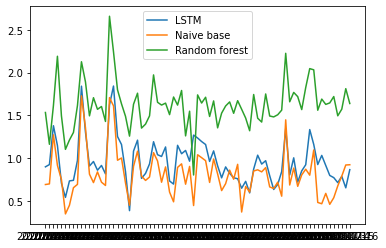

In [177]:
import matplotlib.pyplot as plt
plt.plot(AAPL_DF.Date,AAPL_DF.lstm)
plt.plot(AAPL_DF.Date,AAPL_DF.nb)
plt.plot(AAPL_DF.Date,AAPL_DF.rf)
plt.legend(["LSTM","Naive base","Random forest"])

<function matplotlib.pyplot.show(close=None, block=None)>

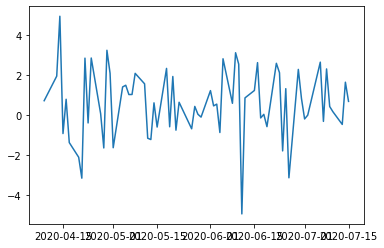

In [178]:
plt.plot(calc_Return(apple_data).Date,calc_Return(apple_data).Values)
plt.show

In [180]:
calc_Return(apple_data),AAPL_DF

(         Date    Values
 0  2020-04-09  0.719017
 1  2020-04-13  1.943750
 2  2020-04-14  4.926925
 3  2020-04-15 -0.916922
 4  2020-04-16  0.791435
 ..        ...       ...
 62 2020-07-09  0.429110
 63 2020-07-10  0.174773
 64 2020-07-13 -0.462386
 65 2020-07-14  1.641299
 66 2020-07-15  0.685378
 
 [67 rows x 2 columns],
           Date      lstm        rf        nb
 0   2020-04-09  0.896522  1.532977   0.68945
 1   2020-04-10  0.923048  1.160622  0.696764
 2   2020-04-11  1.378018  1.614757  1.271348
 3   2020-04-12  1.146079  2.191654  0.912776
 4   2020-04-13  0.705439  1.493405   0.74798
 ..         ...       ...       ...       ...
 72  2020-07-12  0.770108  1.719786  0.534834
 73  2020-07-13  0.711456  1.494418  0.673301
 74  2020-07-14  0.784955  1.571796  0.787502
 75  2020-07-15  0.650717  1.812083  0.918072
 76  2020-07-16  0.863442   1.63825  0.921114
 
 [77 rows x 4 columns])

In [220]:
import time
import datetime
def finalRes(return_data,bullishness_data):
    fin = pd.DataFrame(columns=['Date','lstm','rf','nb','Values'])
    l =[]
    for i in range(1,len(return_data.index)):
        for j in range(0,len(bullishness_data.index)):
            if datetime.datetime.strptime(bullishness_data.Date.iloc[j],"%Y-%m-%d")>=return_data.Date.iloc[i]:
                l.append([bullishness_data.Date.iloc[j-1],bullishness_data.lstm.iloc[j-1],bullishness_data.rf.iloc[j-1],bullishness_data.nb.iloc[j-1],return_data.Values.iloc[i]])
                break
    fin = pd.DataFrame(l,columns=['Date','lstm','rf','nb','Values'])
    return fin

            


In [221]:
res = finalRes(calc_Return(apple_data),AAPL_DF)

In [222]:
res

,Date,lstm,rf,nb,Values
0,2020-04-12,1.146079,2.191654,0.912776,1.943750
1,2020-04-13,0.705439,1.493405,0.747980,4.926925
2,2020-04-14,0.538997,1.101498,0.345130,-0.916922
3,2020-04-15,0.731508,1.210670,0.446473,0.791435
4,2020-04-16,0.738830,1.299283,0.652214,-1.366161
...,...,...,...,...,...
61,2020-07-08,0.923239,1.559566,0.479508,0.429110
62,2020-07-09,1.030351,1.690234,0.464173,0.174773
63,2020-07-12,0.770108,1.719786,0.534834,-0.462386
64,2020-07-13,0.711456,1.494418,0.673301,1.641299


In [286]:
import matplotlib.pyplot as plt
def cm_to_inch(value):
    return value/2.54
def drawPlot(date,y1,y2,modelTitle):
    fig, ax1 = plt.subplots()
    fig.suptitle(modelTitle, fontsize=16)
    fig.set_size_inches(18.5, 10.5, forward=True)
    ax2 = ax1.twinx()
    ax1.plot(date,y1 , 'r-')
    ax2.plot(date,y2 , 'b-')

    ax1.set_xlabel('X data')
    ax1.set_ylabel('return ', color='r')
    ax2.set_ylabel('bullishness ', color='b')

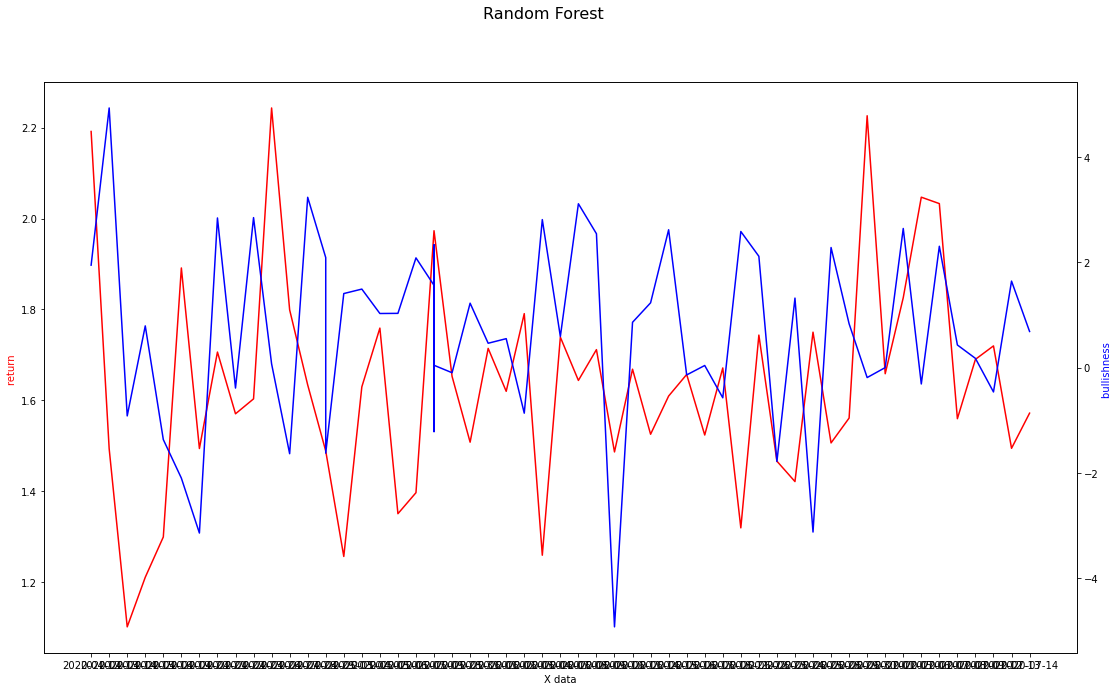

In [287]:
drawPlot(res.Date,res.rf,res.Values,'Random Forest')

In [288]:
def drawAllForStock(data,str):
    bull = bullishness(data) 
    start = bull['Date'].iloc[0]
    end = bull['Date'].iloc[-1]
    stock_data = yf.download(str, start=start, end=end)
    stock_data.drop(apple_data.columns.difference(['Close']), 1, inplace=True)
    ret = calc_Return(stock_data)
    res = finalRes(ret,bull)
    drawPlot(res.Date,res.lstm,res.Values,"lstm model")
    drawPlot(res.Date,res.rf,res.Values,"Random forest model")
    drawPlot(res.Date,res.nb,res.Values,"Naïve Bayes model")

[*********************100%***********************]  1 of 1 completed


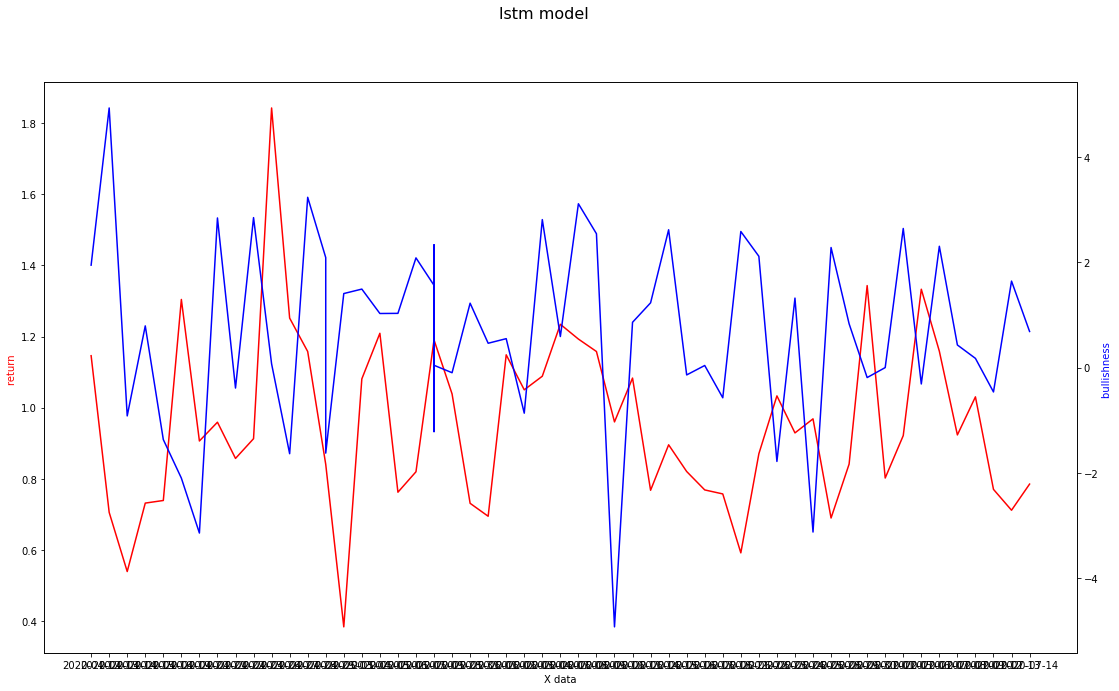

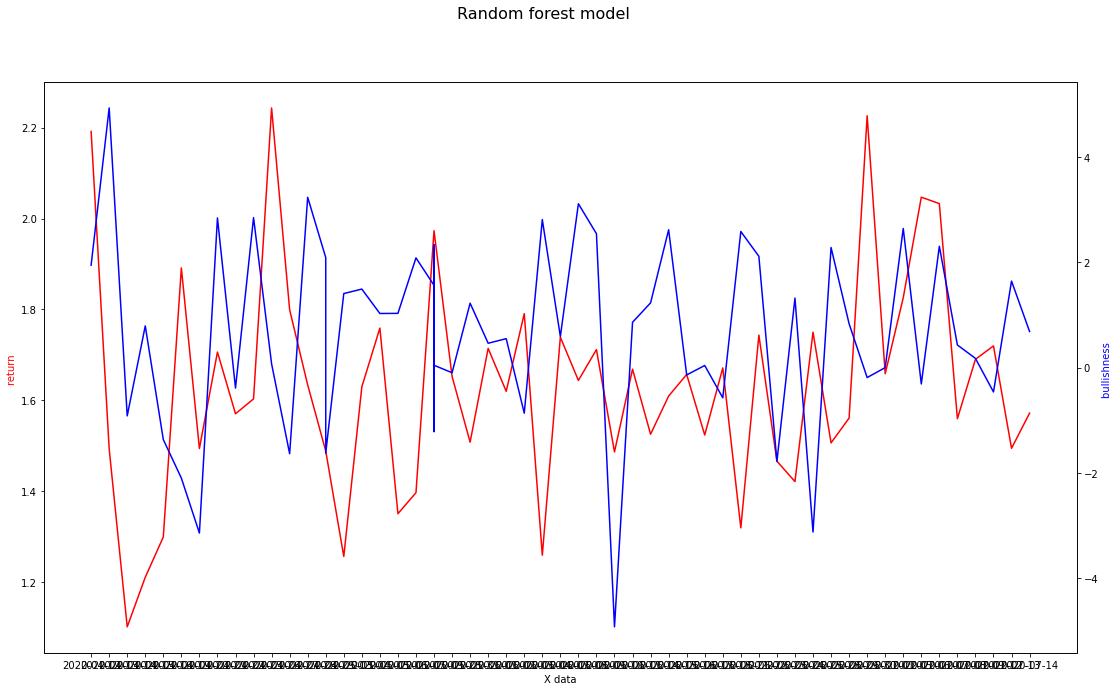

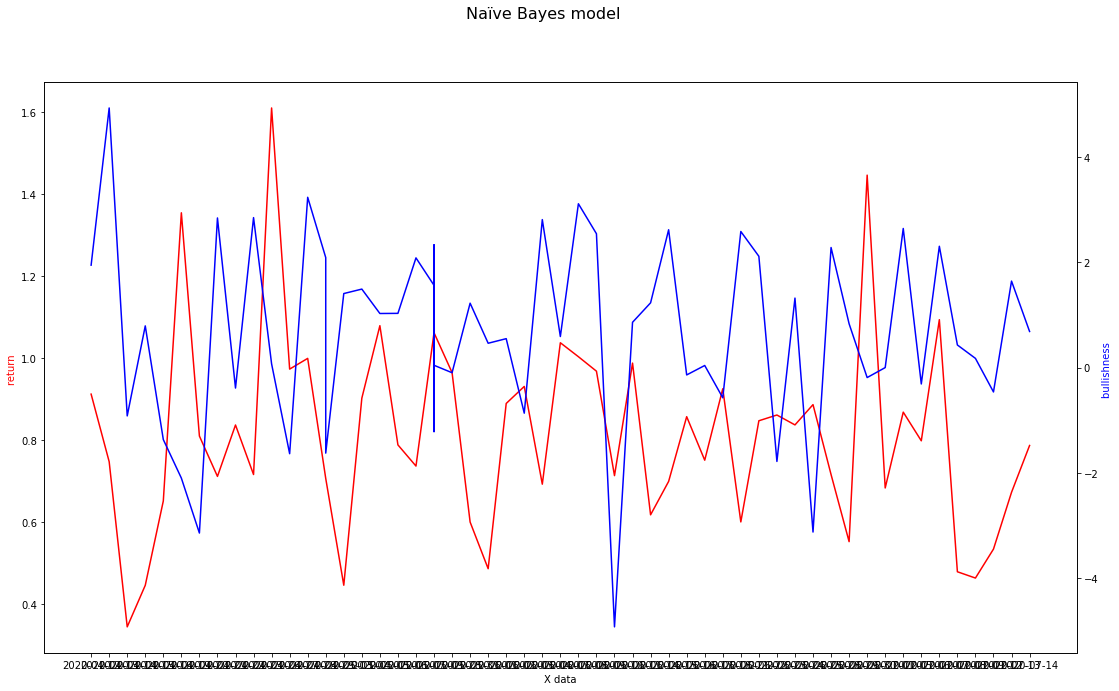

In [289]:
drawAllForStock(AAPL_DF,'AAPL')